# Quantized Neural Network 
## 02- Quantization Basics

by [Soon Yau Cheong](http://www.linkedin.com/in/soonyau)


Quantization isn't something new, it has been around for many years and have been extensively since the creation of digital electronics. In digital signal processing, quantization usually refers to converting continuous signal e.g. light, sound into discrete digital number. In deep learning, quantization genereally means converting signed single precision floating point (float32) to lower precision number format such as unsigned 8-bit integer (uint8). I wrote a [blog](https://medium.com/@soon_yau/speeding-up-deep-learning-with-quantization-3fe3538cbb9) introducing quantization which I'll summarize here. Although quantization from float32 to uint8 can reduce memory for 4x but it is not mainly to save storage but rather to speed up the inference. This can happen for 2 reasons:
- Deep neural networks have a lot of parameters (weights) and loading them from memory can become the bottleneck rather than the actual computation, so is moving the activations back the the main memory
- Fixed point computation is usually faster than the floating point counterpart. In some embedded platforms, floating point CPU is simply not available.



In this tutorial, we'll learn to quantize a full precision graph into uint8 graph, and also study how the computation works in a quantized network.







In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf

print("Tensorflow", tf.__version__)
print("Python", sys.version)

Tensorflow 1.10.0
Python 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


## Converting from float32 into unsigned integer (uint)
As mentioned in my blog, the quantization equation is as follow:
\begin{equation}
x_{uint8} = \frac{x_{float}}{x_{scale}} + x_{offset}
\end{equation}

In quantization, we want to map the the minimum of float32 to minimum of unsigned integer (0), and the maximum of float32 to maximum of unsigned integer therefeore, the x_scale is the inverse of slope of linear equation.


\begin{equation}
x_{scale} = \frac{max(x_{float}) - min(x_{float})}{2^N-1}
\end{equation}

$x_{offset}$ is an uint8 which in fact is quantized value that corresponds to 0 of real value (floating point numbers). N is bitwidth of quantized integer.

Dequantization is simply the reverse of the above process to convert from integer back to floating point number.

Below are the code to perform quantization and dequantization.

In [2]:
# set seed to ensure same random numbers are generated everytime
np.random.seed(1515)

# generate some random float numbers. By default, the generated numbers are in float64,
# we cast it into float32. It is important to set the data type explicitly to make sure
# correct arithmetic operation are used
x = (1*np.random.randn(9,9)).astype(np.float32)

def sat_uint(x, num_bits=8):
    return np.uint8(np.clip(np.round(x), 0, 2**num_bits-1))
    
def quantize(x_float, num_bits=8, print_debug=False):
    # calculate scale
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min

    quant_min = 0    
    quant_max = 2**num_bits - 1

    x_scale = (x_max - x_min)/(quant_max - quant_min)
    
    # calculate offset
    x_offset = sat_uint(quant_max - x_max/x_scale, num_bits)
    
    # quantize
    x_quant = x_float/x_scale + x_offset

    if print_debug:
        print("min = %f \nmax = %f \nnum_bits = %d \nscale = %.8f \noffset = %d"\
              %(x_min, x_max, num_bits, x_scale, x_offset))
    return sat_uint(x_quant, num_bits), x_scale, x_offset

def dequantize(x_quant, x_scale, x_offset):
    
    x_quant = x_quant.astype(np.float32)
    
    x_dequant = (x_quant - x_offset) * x_scale
    
    return x_dequant


x_quant, x_scale, x_offset = quantize(x, 8, True)

x_dequant = dequantize(x_quant, x_scale, x_offset)


min = -2.398871 
max = 2.760502 
num_bits = 8 
scale = 0.02023283 
offset = 119


If we plot the original floating point (x-axis) against quantized integer (y-axis) we can see that it is merely a linear mapping where the offset is quantized value that represent real-value of zero. 

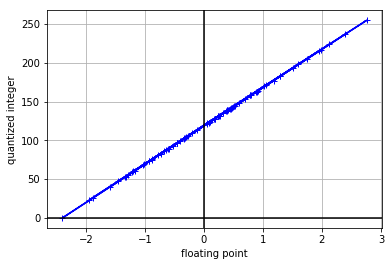

In [3]:
fig, ax = plt.subplots()
ax.plot(x, x_quant, marker='+',color='b')
ax.set_xlabel("floating point")
ax.set_ylabel("quantized integer")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

##  tf.fake_quant_with_min_max_args 

In fact, the quantize-dequantize cycle we have implemented is exactly tf.fake_quant_with_min_max_args is doing.

In [3]:
inputs = tf.placeholder(tf.float32)
fake_quantized_x = tf.fake_quant_with_min_max_args(inputs, np.min(x), np.max(x), num_bits=8)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    fake_x = sess.run(fake_quantized_x, feed_dict={inputs:x})

np.testing.assert_array_almost_equal(fake_x, x_dequant)

## Offset

It is worth mentioning why offset is rounded and cast to unsigned integer rather than leaving it as float. Let's use an example. If the floating numbers range is +-1.0, then 

\begin{equation}
x_{scale} = \frac{2}{255},  x_{offset} = 127.5
\end{equation}
and therefore
\begin{equation}
x_{uint8} = round(127.5) = 128 
\end{equation}
as the number will need to be cast into integer. Remember, decimal point is exclusive to floating point and don't exist in integer representation. 

Now if we de-quantize it

\begin{equation}
x_{dequant} = (x_{quant} - x_{offset}) \times x_{scale}
\end{equation}
\begin{equation}
x_{dequant} = (128 - 127.5) \times \frac{2}{255}
\end{equation}
\begin{equation}
x_{dequant} = 0.003921569
\end{equation}

and the dequantized value is no longer 0. As 0 happens a lot in weights, activation and also used frequently as padding, we want to represent it precisely at the expense of moving the quantization error to other values.

## Quantization Loss

As shown earlier, rounding can create discrepancy in dequantized offset. Some information will be lost after quantization, we compare the error between the original and dequantized values and plot them on a graph and we can see that they are in fact non-zero despite not too big either. The error magnitude depends on the real values' range, distribution and quantization bit numbers. 

error -0.010020614 0.009811968


Text(0, 0.5, 'quantization error')

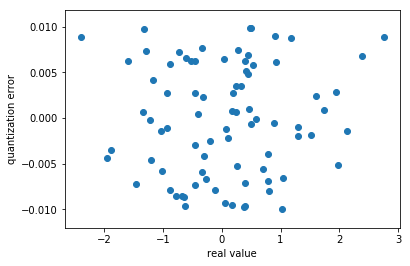

In [4]:
error = np.reshape(x-x_dequant, (-1))
print("error", np.min(error), np.max(error))
fig, ax = plt.subplots()
ax.scatter(x, error)
ax.set_ylim([1.2*min(error), 1.2*max(error)])
ax.set_xlabel("real value")
ax.set_ylabel("quantization error")

The error magnitude depends on the real values' range, distribution and quantization bit numbers. Since we don't realy control over the neural network's input and weight distribution, we'll examine the impact of quantization bitwidth on the error. As shown in the graph below, the error increase almost exponentially as the bitwidth decreases.

Text(0.5, 0, 'bitwidth')

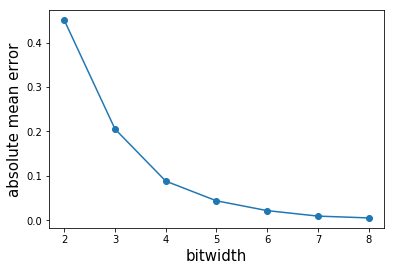

In [5]:
bitwidths = [i for i in range(2,9)]
bit_errors = []

for num_bits in bitwidths:

    x_quant, x_scale, x_offset = quantize(x, num_bits)

    x_dequant = dequantize(x_quant, x_scale, x_offset)

    error = np.reshape(x-x_dequant, (-1))

    abs_error = np.mean(np.abs(error))

    bit_errors.append(abs_error)


fig, ax = plt.subplots()
ax.plot(bitwidths, bit_errors, marker="o")
ax.set_ylabel("absolute mean error", fontsize=15)
ax.set_xlabel("bitwidth", fontsize=15)

# What's Next?

In this tutoral, we have learn the basics of quantization, de-quantization and quantization loss (error). Next we will apply this new learned knowledge to perform actual computation in neural network and explore optimization methods to reduce computational efforts.